# <center> Задача восстановления регрессии</center>

### Часть 1. Первичный анализ данных c Pandas

В этом заданиии мы будем использовать данные [SOCR](http://wiki.stat.ucla.edu/socr/index.php/SOCR_Data_Dinov_020108_HeightsWeights) по росту и весу 25 тысяч подростков.

**[1]. Если у Вас не установлена библиотека Seaborn - выполните в терминале команду *conda install seaborn*. (Seaborn не входит в сборку Anaconda, но эта библиотека предоставляет удобную высокоуровневую функциональность для визуализации данных).**

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Считаем данные по росту и весу (*weights_heights.csv*, приложенный в задании) в объект Pandas DataFrame:

In [4]:
data = pd.read_csv('weights_heights.csv', index_col='Index')

In [3]:
df=data

In [6]:
1 / data.len

AttributeError: 'DataFrame' object has no attribute 'len'

Чаще всего первое, что надо надо сделать после считывания данных - это посмотреть на первые несколько записей. Так можно отловить ошибки чтения данных (например, если вместо 10 столбцов получился один, в названии которого 9 точек с запятой). Также это позволяет познакомиться с данными, как минимум, посмотреть на признаки и их природу (количественный, категориальный и т.д.). 

После этого стоит построить гистограммы распределения признаков - это опять-таки позволяет понять природу признака (степенное у него распределение, или нормальное, или какое-то еще). Также благодаря гистограмме можно найти какие-то значения, сильно не похожие на другие - "выбросы" в данных. 
Гистограммы удобно строить методом *plot* Pandas DataFrame с аргументом *kind='hist'*.

**Пример.** Построим гистограмму распределения роста подростков из выборки *data*. Используем метод *plot* для DataFrame *data* c аргументами *y='Height'* (это тот признак, распределение которого мы строим)

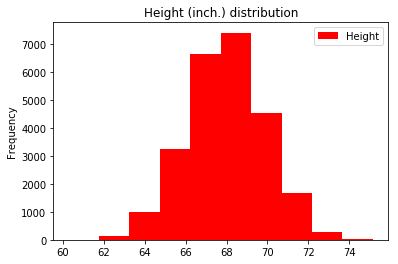

In [4]:
data.plot(y='Height', kind='hist', 
           color='red',  title='Height (inch.) distribution');

Аргументы:

- *y='Height'* - тот признак, распределение которого мы строим
- *kind='hist'* - означает, что строится гистограмма
- *color='red'* - цвет

**[2]. Посмотрите на первые 5 записей с помощью метода *head* Pandas DataFrame. Нарисуйте гистограмму распределения веса с помощью метода *plot* Pandas DataFrame. Сделайте гистограмму зеленой, подпишите картинку.**

In [5]:
df.head()

,Height,Weight
Index,,
1,65.78331,112.9925
2,71.51521,136.4873
3,69.39874,153.0269
4,68.21660,142.3354
5,67.78781,144.2971


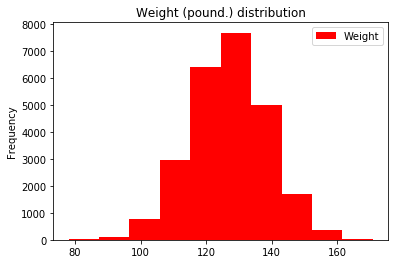

In [6]:
data.plot(y='Weight', kind='hist', 
           color='red',  title='Weight (pound.) distribution');

Один из эффективных методов первичного анализа данных - отображение попарных зависимостей признаков. Создается $m \times m$ графиков (*m* - число признаков), где по диагонали рисуются гистограммы распределения признаков, а вне диагонали - scatter plots зависимости двух признаков. Это можно делать с помощью метода $scatter\_matrix$ Pandas Data Frame или *pairplot* библиотеки Seaborn. 

Чтобы проиллюстрировать этот метод, интересней добавить третий признак. Создадим признак *Индекс массы тела* ([BMI](https://en.wikipedia.org/wiki/Body_mass_index)). Для этого воспользуемся удобной связкой метода *apply* Pandas DataFrame и lambda-функций Python.

In [7]:
def make_bmi(height_inch, weight_pound):
    METER_TO_INCH, KILO_TO_POUND = 39.37, 2.20462
    return (weight_pound / KILO_TO_POUND) / \
           (height_inch / METER_TO_INCH) ** 2

In [8]:
data['BMI'] = data.apply(lambda row: make_bmi(row['Height'], 
                                              row['Weight']), axis=1)

**[3]. Постройте картинку, на которой будут отображены попарные зависимости признаков , 'Height', 'Weight' и 'BMI' друг от друга. Используйте метод *pairplot* библиотеки Seaborn.**

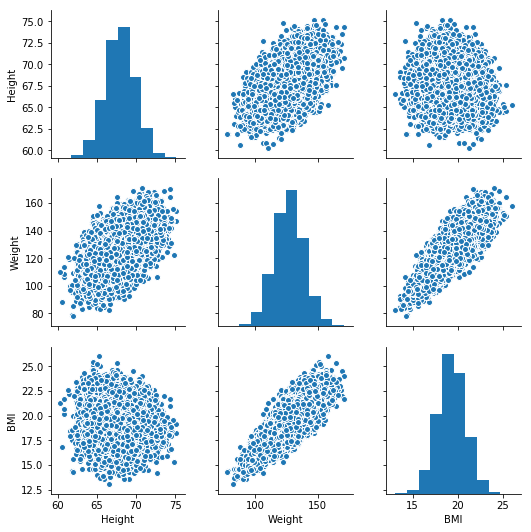

In [9]:
sns.pairplot(df)

Часто при первичном анализе данных надо исследовать зависимость какого-то количественного признака от категориального (скажем, зарплаты от пола сотрудника). В этом помогут "ящики с усами" - boxplots библиотеки Seaborn. Box plot - это компактный способ показать статистики вещественного признака (среднее и квартили) по разным значениям категориального признака. Также помогает отслеживать "выбросы" - наблюдения, в которых значение данного вещественного признака сильно отличается от других. 

**[4]. Создайте в DataFrame *data* новый признак *weight_category*, который будет иметь 3 значения: 1 – если вес меньше 120 фунтов. (~ 54 кг.), 3 - если вес  больше или равен 150 фунтов (~68 кг.), 2 – в остальных случаях. Постройте «ящик с усами» (boxplot), демонстрирующий зависимость роста от весовой категории. Используйте метод *boxplot* библиотеки Seaborn и метод *apply* Pandas DataFrame. Подпишите ось *y* меткой «Рост», ось *x* – меткой «Весовая категория».**

In [10]:
def weight_category(weight):
    return 1 if weight < 120 else 2 if weight < 150 else 3

data['weight_cat'] = data['Weight'].apply(weight_category)

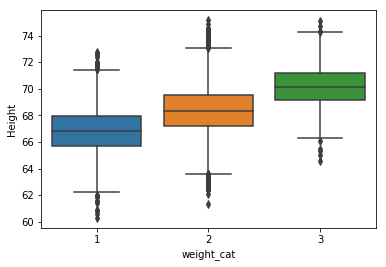

In [11]:
sns.boxplot(x=df['weight_cat'], y=data['Height'])

**[5]. Постройте scatter plot зависимости роста от веса, используя метод *plot* для Pandas DataFrame с аргументом *kind='scatter'*. Подпишите картинку.**

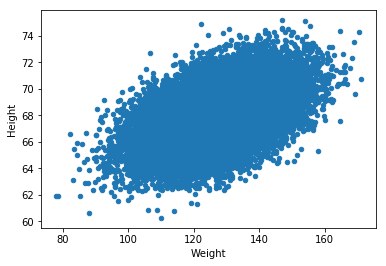

In [12]:
df.plot(x='Weight', y='Height', kind='scatter')

## Часть 2. Минимизация квадратичной ошибки

В простейшей постановке задача прогноза значения вещественного признака по прочим признакам (задача восстановления регрессии) решается минимизацией квадратичной функции ошибки. 

**[6]. Напишите функцию, которая по двум параметрам $w_0$ и $w_1$ вычисляет квадратичную ошибку приближения зависимости роста $y$ от веса $x$ прямой линией $y = w_0 + w_1 * x$:**

$$error(w_0, w_1) = \sum_{i=1}^n {(y_i - (w_0 + w_1 * x_i))}^2 $$
Здесь $n$ – число наблюдений в наборе данных, $y_i$ и $x_i$ – рост и вес $i$-ого человека в наборе данных. 

In [14]:
div1len = np.divide(1, len(df))

def sqErr(x, y, w, b):
    return np.square(np.subtract(np.add(np.multiply(w, x), b), y))

def Q(w, b):
    return np.multiply(np.sum(df.apply(lambda r: sqErr(r['Weight'], r['Height'], w, b), axis=1)), div1len)

**[7]. Напишите функцию, которая по итеративно подбирает параметры $w_0$ и $w_1$. 
На каждом шаге обновления параметров сохраняйте среднюю ошибку. 
Нарисуйте график убывания ошибки в зависимости от итерации**

В данном задании удобно будет разделить Ваш код на несколько функций. Одна будет предсказывать рост по весу используя формулу $w_0$ + $w_1$ * $x$, другая -- среднеквадратичную ошибку, третья -- выполнять обновление параметров $w_0$ и $w_1$.

In [35]:
w = 1
b = 1


def pred(w, b):
    calc = lambda x, y: (np.subtract(np.add(np.multiply(w, x), b), y), x)
    app = df.apply(lambda r: calc(r['Weight'], r['Height']), axis=1)
    return app

div2len = np.multiply(div1len, 2)

def opt_gradw(w, b, prd):
    app = prd.apply(lambda p: p[0] * p[1])
    return np.multiply(div2len, np.sum(app))


def opt_gradb(w, b, prd):
    y = prd.apply(lambda p: p[0])
    return np.multiply(div2len, np.sum(y))


def train(rate, w, b):
    prd = pred(w, b)
    w += np.multiply(-rate, opt_gradw(w, b, prd))
    b += np.multiply(-rate, opt_gradb(w, b, prd))
    return w, b


step = 1e-5
errors = [Q(w, b)]
ws = [w]
bs = [b]
i=0
while True:
    w, b = train(step, w, b)
    errors.append(Q(w, b))
    ws.append(w)
    bs.append(b)
    i += 1
    print(i, errors[-1])
    if np.abs(errors[-2] - errors[-1]) < 1e-2:
        break
print(errors, w, b)

1 1710.82281561
2 793.872724567
3 376.981647047
4 187.442243924
5 101.268208595
6 62.0892054662
7 44.2764790569
8 36.1779236883
9 32.495913151
10 30.8218833424
11 30.0607813454
12 29.7147416929
13 29.5574100058
14 29.4858743363
15 29.4533457993
16 29.438551843
17 29.4318209083
[3727.6505199199946, 1710.8228156121761, 793.87272456671974, 376.98164704650719, 187.44224392406787, 101.2682085950907, 62.089205466247691, 44.27647905694144, 36.177923688346091, 32.495913150976868, 30.82188334243029, 30.060781345420953, 29.714741692944077, 29.557410005841941, 29.48587433629033, 29.453345799337587, 29.438551843045701, 29.431820908316766] 0.524072842685 0.996446757379


In [37]:
w2 = 0
b2 = 0
errors2 = [Q(w2, b2)]
ws2 = [w2]
bs2 = [b2]
i = 0
while True:
    w2, b2 = train(step, w2, b2)
    errors2.append(Q(w2, b2))
    ws2.append(w2)
    bs2.append(b2)
    i += 1
    print(i, errors2[-1])
    if np.abs(errors2[-2] - errors2[-1]) < 1e-2:
        break

1 2120.08181201
2 980.457844173
3 462.328157909
4 226.760652753
5 119.65995503
6 70.9666512044
7 48.8282507811
8 38.7630289001
9 34.1868738747
10 32.1063213815
11 31.1603938007
12 30.730323082
13 30.5347865247
14 30.4458808506
15 30.4054548743
16 30.3870701775
17 30.3787065415


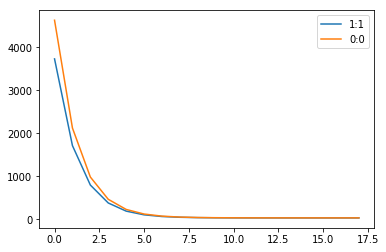

In [44]:
plt.plot(errors, label='1:1')
plt.plot(errors2, label='0:0')
plt.legend()

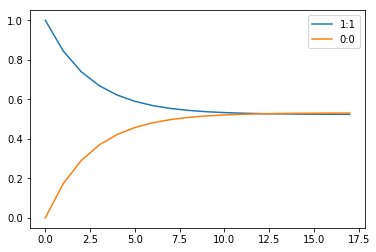

In [45]:
plt.plot(ws, label='1:1')
plt.plot(ws2, label='0:0')
plt.legend()

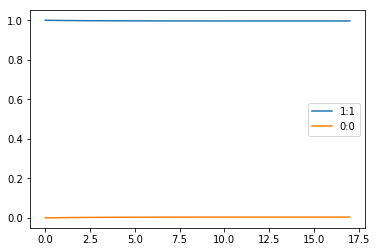

In [46]:
plt.plot(bs, label='1:1')
plt.plot(bs2, label='0:0')
plt.legend()

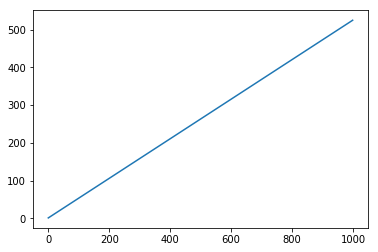

In [23]:
plt.plot(range(1000), [w * x + b for x in range(1000)])